## 2. Unzip data 

In [5]:
import zipfile
from pathlib import Path

zip_path = Path('../Data/data.zip')
extract_to = Path('data')

Path(extract_to).mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f'Extracted {zip_path} to {extract_to}')

Extracted ..\Data\data.zip to data


### 2.2. Split images into train and validation folders

Ultralytics requires a particular folder structure to store training data for models. Ultralytics requires a particular folder structure to store training data for models. The root folder is named “data”. Inside, there are two main folders:

- Train: These are the actual images used to train the model. In one epoch of training, every image in the train set is passed into the neural network. The training algorithm adjusts the network weights to fit the data in the images.

- Validation: These images are used to check the model's performance at the end of each training epoch.

In each of these folders is a “images” folder and a “labels” folder, which hold the image files and annotation files respectively.


I wrote a Python script that will automatically create the required folder structure and randomly move 90% of dataset to the "train" folder and 10% to the "validation" folder. Run the following code block to download and execute the scrpt.

I did in terminal: 
`python train_val_split.py --datapath data --train_pct 0.8`


## 3. Configure training

In [7]:
import yaml
from pathlib import Path

classes_txt = Path("data/classes.txt")
output_yaml = Path("data/data.yaml")

with open(classes_txt) as f:
    names = [line.strip() for line in f if line.strip()]

data = {
    "path": "data",
    "train": "train/images",
    "val": "validation/images",
    "nc": len(names),
    "names": names
}

output_yaml.parent.mkdir(parents=True, exist_ok=True)

with open(output_yaml, "w") as f:
    yaml.dump(data, f, sort_keys=False)

print("✅ data.yaml created at data/data.yaml")
print(data)

✅ data.yaml created at data/data.yaml
{'path': 'data', 'train': 'train/images', 'val': 'validation/images', 'nc': 6, 'names': ['OK_NoIssue', 'S1_AxisNotZero', 'S2_UnequalTickSpacing', 'S3_DistortedScaleRange', 'S4_MissingAxisValues', 'S5_MisusedDualAxis']}


# 4.Train model

In [8]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [12]:

from ultralytics import YOLO
model = YOLO("yolov8n.pt")
#model.train(data="data/data.yaml", epochs=60, imgsz=640, batch=16, device=0) # Use device='cpu' if no GPU is available
model.train(data="data/data.yaml", epochs=60, imgsz=640, batch=16, device=0, name = 'ibcs_v2', exist_ok = True) # Use device='cpu' if no GPU is available

New https://pypi.org/project/ultralytics/8.3.248 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.240  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ibcs_v2, nbs=64, nms=False, opset=None, o

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001BA579F5F30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

# 5. Test model 

I check if the data path match with the real folder data 

In [13]:
from pathlib import Path

for p in [
    "data/train/images", "data/train/labels",
    "data/validation/images", "data/validation/labels"
]:
    path = Path(p)
    print(p, "exists=", path.exists(), "count=", len(list(path.glob("*")) ) if path.exists() else 0)


data/train/images exists= True count= 103
data/train/labels exists= True count= 103
data/validation/images exists= True count= 26
data/validation/labels exists= True count= 26


I check the dectection of models is good or not by counting total objects in labels

In [14]:
from pathlib import Path

def count_objects(split):
    lbl_dir = Path(f"data/{split}/labels")
    total = 0
    for f in lbl_dir.glob("*.txt"):
        lines = [ln for ln in f.read_text().splitlines() if ln.strip()]
        total += len(lines)
    print(split, "total boxes:", total)

count_objects("train")
count_objects("validation")


train total boxes: 111
validation total boxes: 28


Sometimes the model predicts boxes but they get filtered out. So I test with lower confidence during inference (to see if predictions exist at all)

In [15]:
from ultralytics import YOLO
from pathlib import Path

model = YOLO("runs/detect/ibcs_v2/weights/best.pt")  
results = model.predict("data/validation/images", conf=0.01, save=True)

print("Saved to:", results[0].save_dir)

# show how many boxes per image
for r in results[:10]:
    n = 0 if r.boxes is None else len(r.boxes)
    print(Path(r.path).name, "boxes:", n)



image 1/26 c:\Users\teunm\OneDrive\Desktop\Suemy\Group1\group1-jugo\Notebook\data\validation\images\07c67c1e-wc4r4.jpg: 576x640 3 OK_NoIssues, 4 S1_AxisNotZeros, 65.0ms
image 2/26 c:\Users\teunm\OneDrive\Desktop\Suemy\Group1\group1-jugo\Notebook\data\validation\images\0f71c270-images.jpeg: 640x640 2 OK_NoIssues, 3 S1_AxisNotZeros, 3.5ms
image 3/26 c:\Users\teunm\OneDrive\Desktop\Suemy\Group1\group1-jugo\Notebook\data\validation\images\199681cf-trade-deficit-2018-new-baseline.jpg: 480x640 9 S1_AxisNotZeros, 25.1ms
image 4/26 c:\Users\teunm\OneDrive\Desktop\Suemy\Group1\group1-jugo\Notebook\data\validation\images\1d60caf6-Screenshot_2025-12-20_201021.png: 448x640 1 OK_NoIssue, 2 S1_AxisNotZeros, 27.4ms
image 5/26 c:\Users\teunm\OneDrive\Desktop\Suemy\Group1\group1-jugo\Notebook\data\validation\images\2cc7a936-0_7orohiU-4vJChrbt.png: 640x608 10 OK_NoIssues, 6 S1_AxisNotZeros, 25.7ms
image 6/26 c:\Users\teunm\OneDrive\Desktop\Suemy\Group1\group1-jugo\Notebook\data\validation\images\40e387

So we start seeing boxes at conf=0.01 but not at 0.25, your model is weak → needs more data/better training.

Now i test to see how well the model 


image 1/26 c:\Users\teunm\OneDrive\Desktop\Suemy\Group1\group1-jugo\Notebook\data\validation\images\07c67c1e-wc4r4.jpg: 576x640 1 OK_NoIssue, 1 S1_AxisNotZero, 6.6ms
image 2/26 c:\Users\teunm\OneDrive\Desktop\Suemy\Group1\group1-jugo\Notebook\data\validation\images\0f71c270-images.jpeg: 640x640 1 OK_NoIssue, 9.9ms
image 3/26 c:\Users\teunm\OneDrive\Desktop\Suemy\Group1\group1-jugo\Notebook\data\validation\images\199681cf-trade-deficit-2018-new-baseline.jpg: 480x640 3 S1_AxisNotZeros, 7.3ms
image 4/26 c:\Users\teunm\OneDrive\Desktop\Suemy\Group1\group1-jugo\Notebook\data\validation\images\1d60caf6-Screenshot_2025-12-20_201021.png: 448x640 1 OK_NoIssue, 1 S1_AxisNotZero, 8.0ms
image 5/26 c:\Users\teunm\OneDrive\Desktop\Suemy\Group1\group1-jugo\Notebook\data\validation\images\2cc7a936-0_7orohiU-4vJChrbt.png: 640x608 2 OK_NoIssues, 11.1ms
image 6/26 c:\Users\teunm\OneDrive\Desktop\Suemy\Group1\group1-jugo\Notebook\data\validation\images\40e38777-unnamed-chunk-84-1.png: 480x640 1 OK_NoIssu

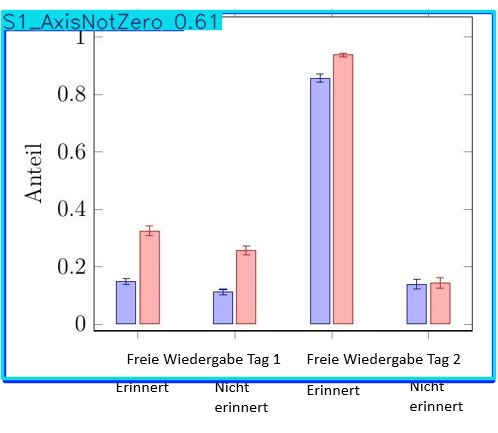

0f71c270-images.jpeg: OK_NoIssue (0.91) → ✅ COMPLIANT


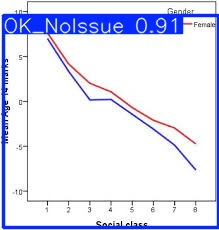

199681cf-trade-deficit-2018-new-baseline.jpg: S1_AxisNotZero (0.78) → ❌ NON-COMPLIANT


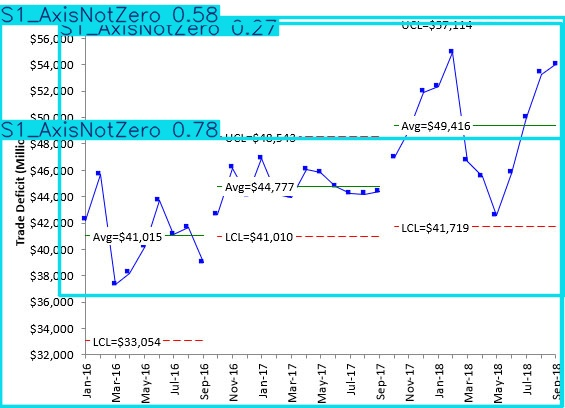

1d60caf6-Screenshot_2025-12-20_201021.png: S1_AxisNotZero (0.57) → ❌ NON-COMPLIANT


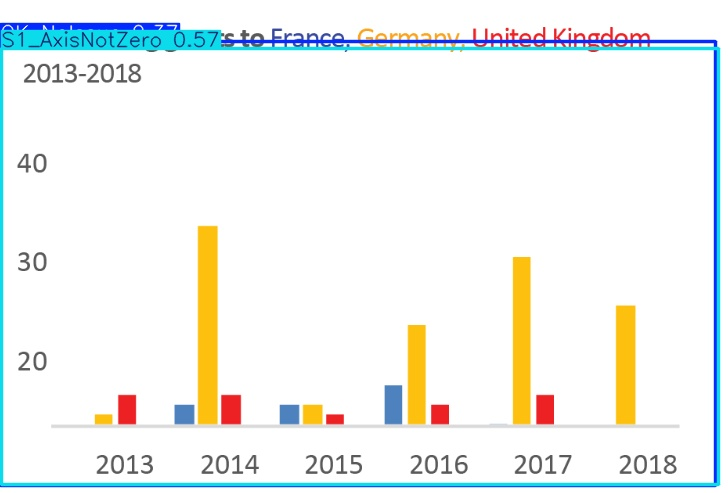

2cc7a936-0_7orohiU-4vJChrbt.png: OK_NoIssue (0.93) → ✅ COMPLIANT


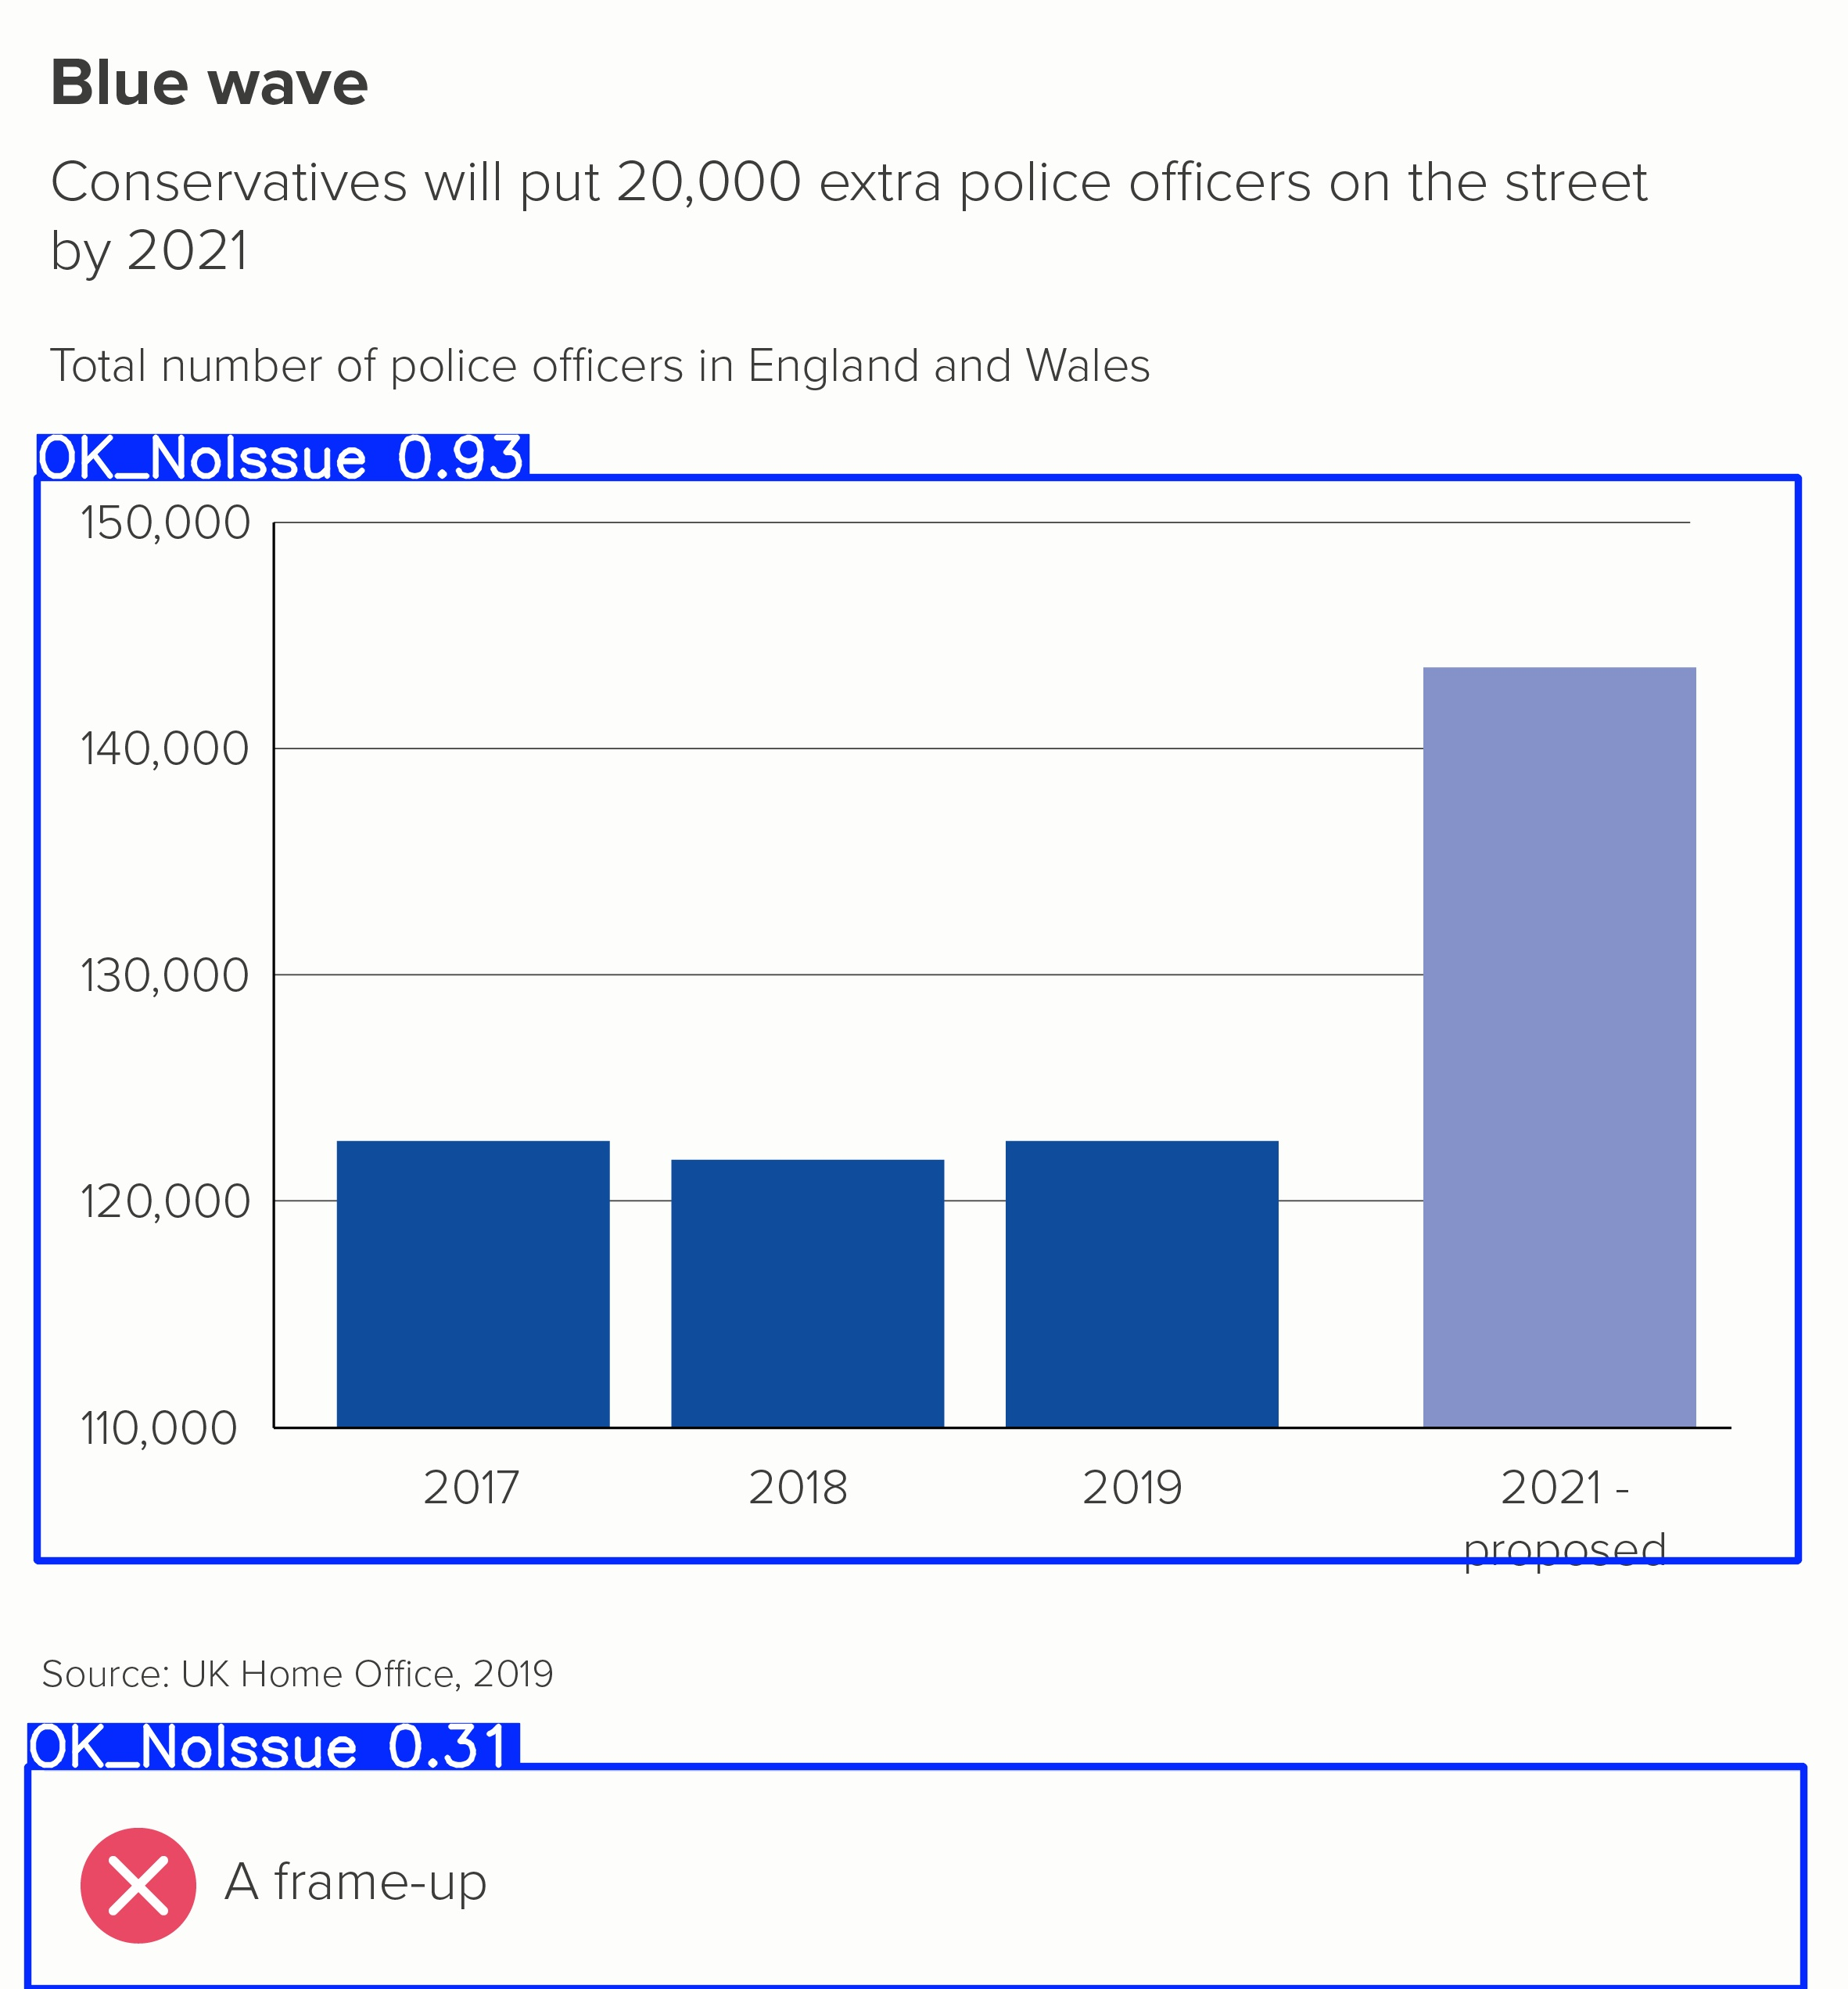

40e38777-unnamed-chunk-84-1.png: OK_NoIssue (0.83) → ✅ COMPLIANT


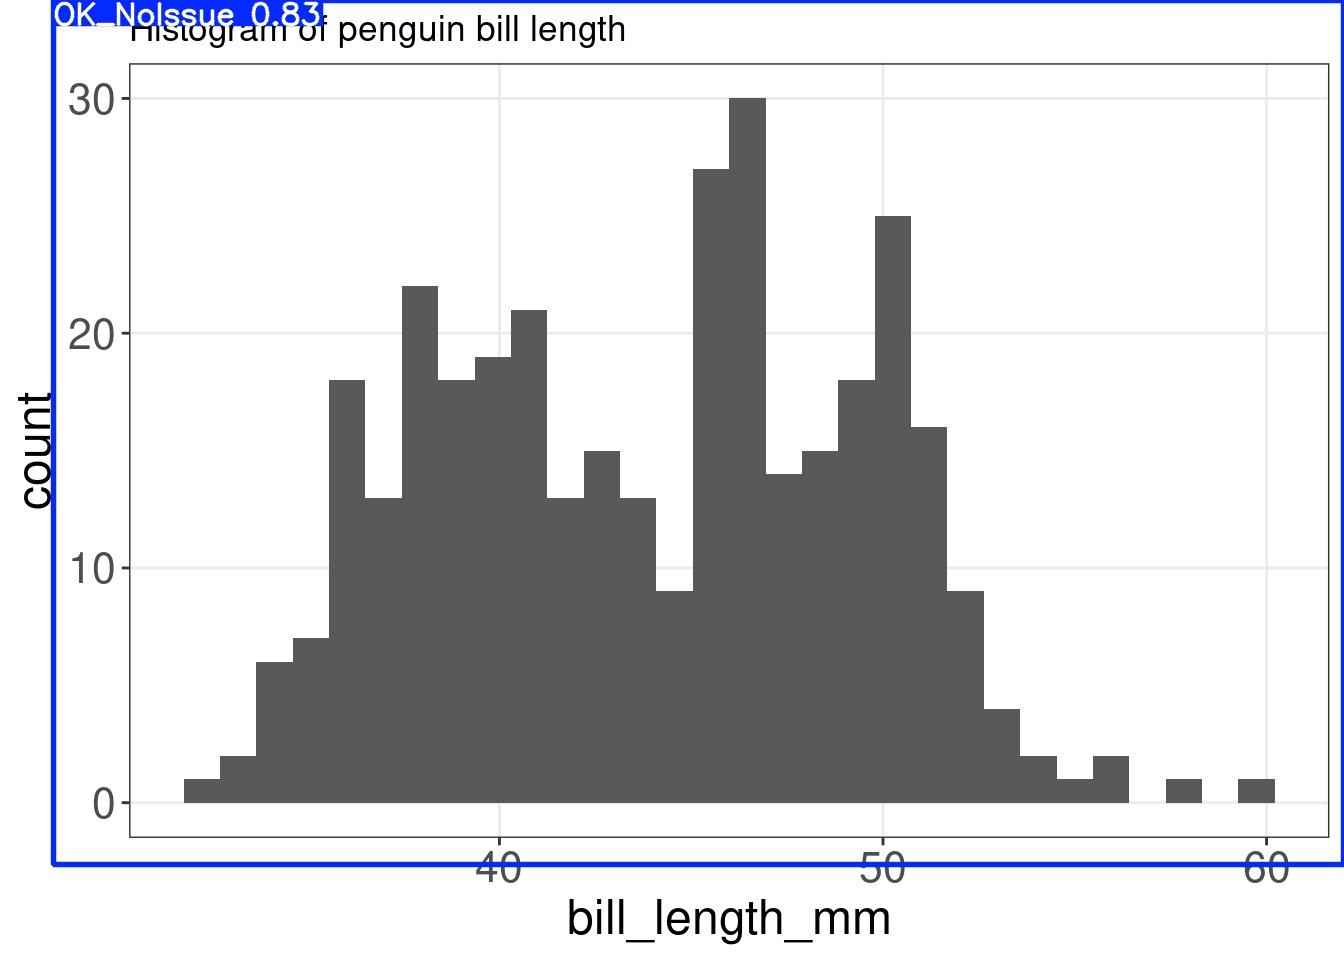

4f80bcbb-xy-scatter-chart.png: OK_NoIssue (0.93) → ✅ COMPLIANT


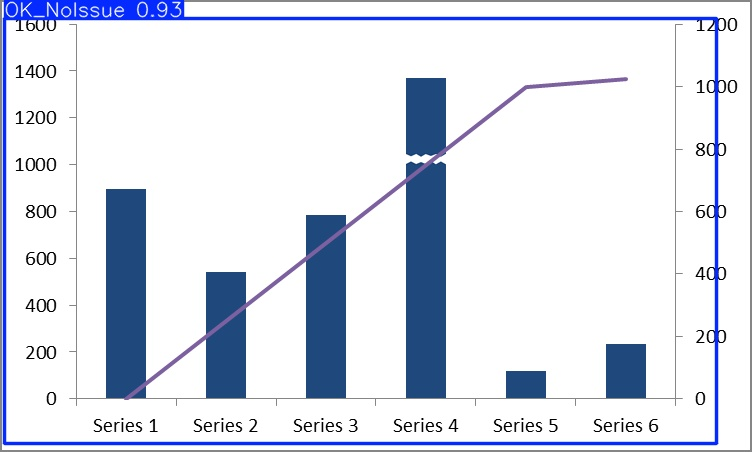

5a896c30-1_o3aY-sOpjigNcguc3DTuUg.png: OK_NoIssue (0.83) → ✅ COMPLIANT


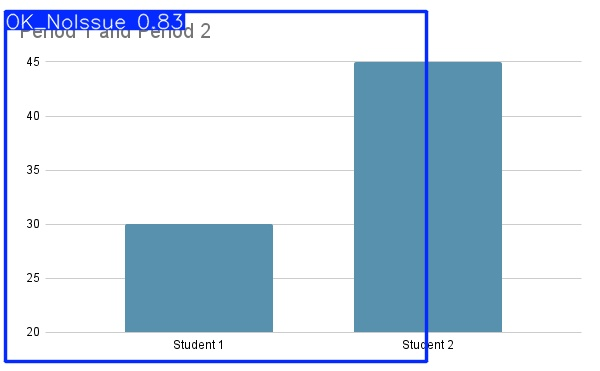

6115c3e1-Screenshot_2025-12-20_200853.png: OK_NoIssue (0.69) → ✅ COMPLIANT


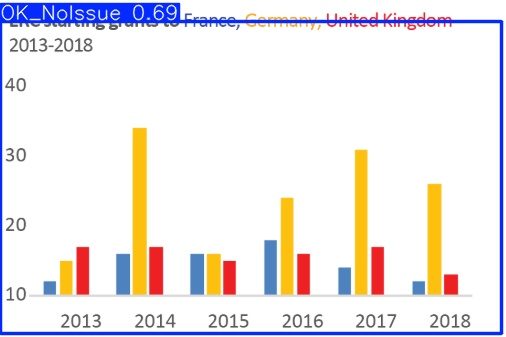

72301072-TP0RH.png: OK_NoIssue (0.81) → ✅ COMPLIANT


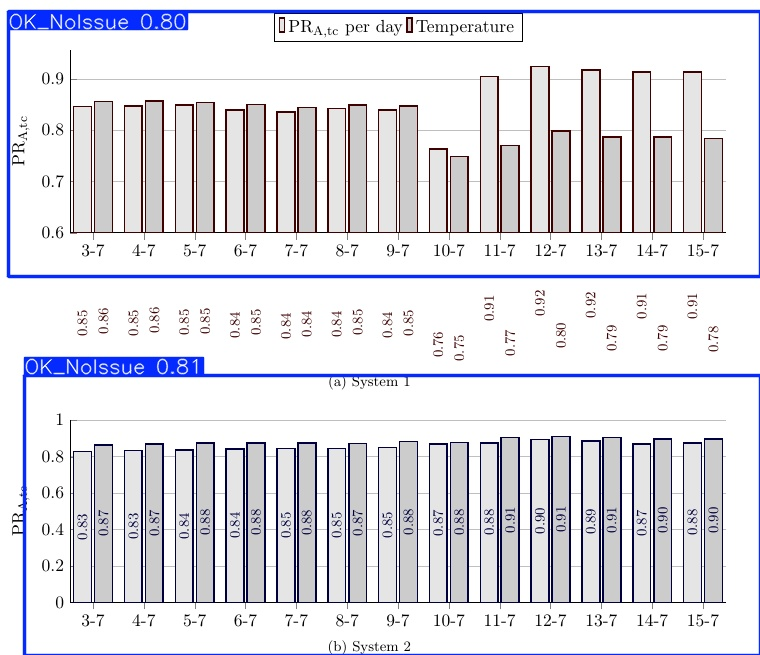

7c2a9fb9-rule_34_lines_zero-01.webp: S1_AxisNotZero (0.88) → ❌ NON-COMPLIANT


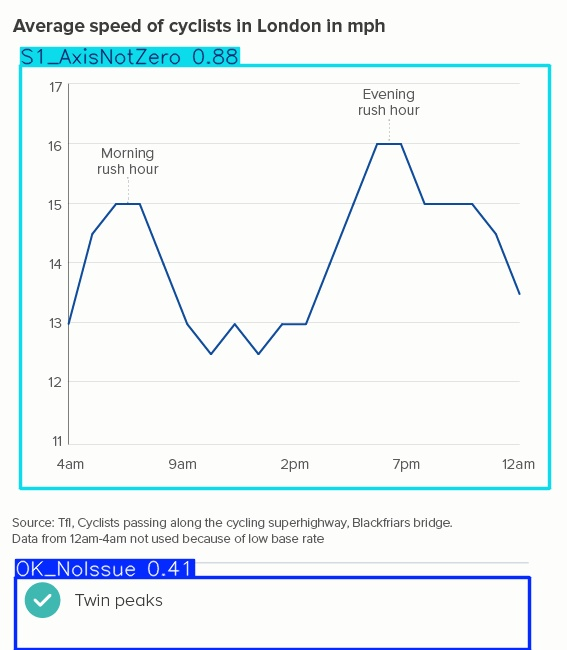

7f4ca29c-statsig1.webp: S1_AxisNotZero (0.76) → ❌ NON-COMPLIANT


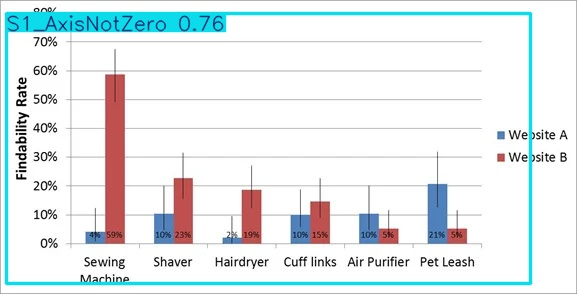

80d6d8a4-renditionDownloa.jpeg: OK_NoIssue (0.96) → ✅ COMPLIANT


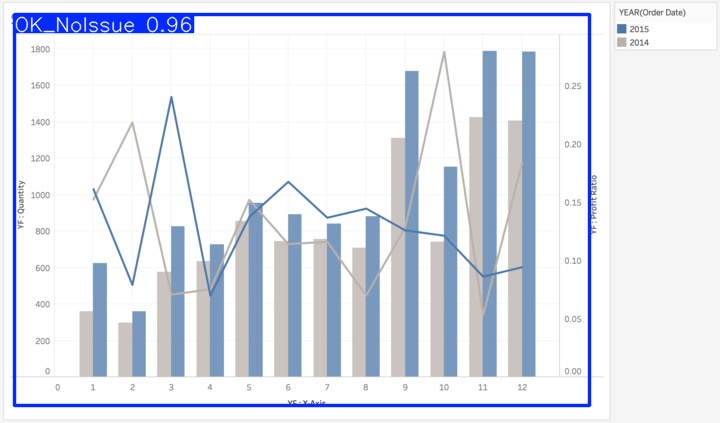

86e9e7c5-Screenshot_2025-12-20_200004.png: S1_AxisNotZero (0.91) → ❌ NON-COMPLIANT


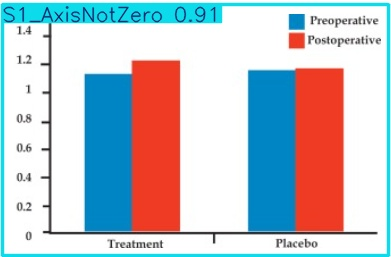

9149f927-41870_2023_1558_Fig19_HTML.png: S1_AxisNotZero (0.90) → ❌ NON-COMPLIANT


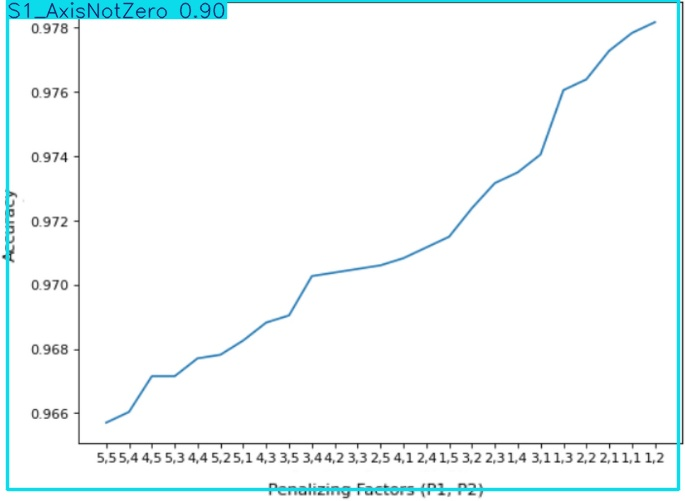

91e971f8-non-connected-axes.png: S1_AxisNotZero (0.97) → ❌ NON-COMPLIANT


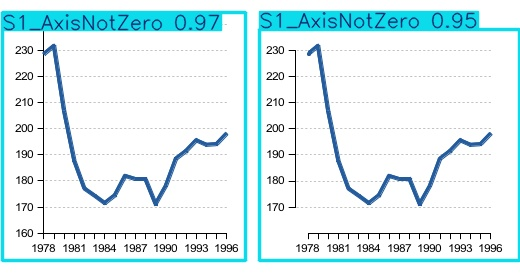

9d731e06-59051883-2b051e00-888e-11e9-9198-860d6242fb45.png: OK_NoIssue (0.79) → ✅ COMPLIANT


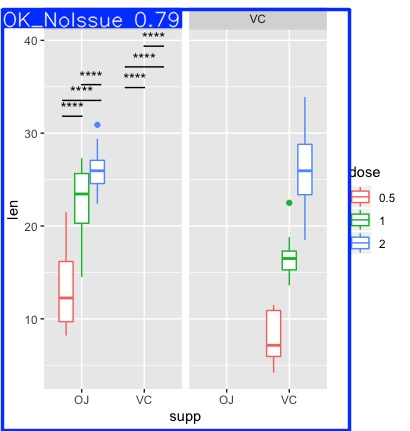

9e2e1d82-temp-zoom.webp: S1_AxisNotZero (0.95) → ❌ NON-COMPLIANT


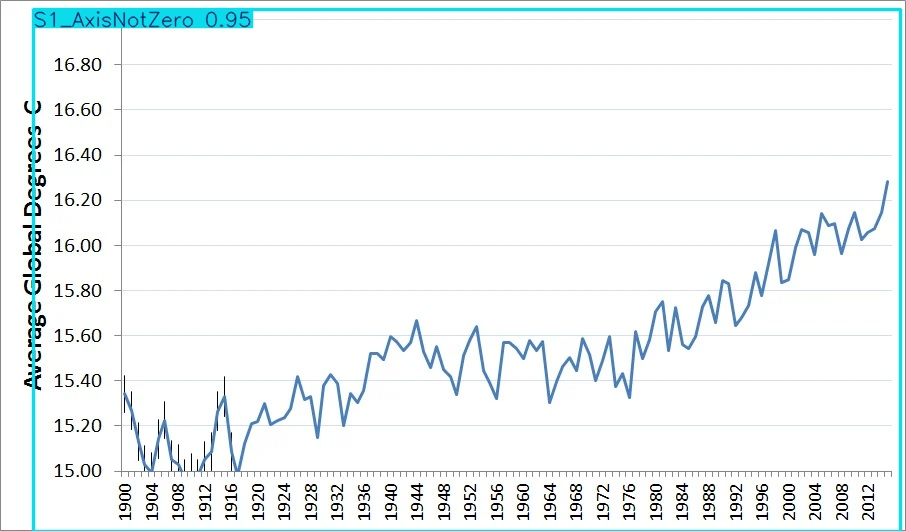

a4597249-Ybroken.png: OK_NoIssue (0.75) → ✅ COMPLIANT


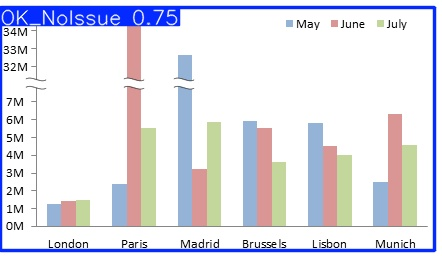

a69e29b2-sst.png: OK_NoIssue (0.91) → ✅ COMPLIANT


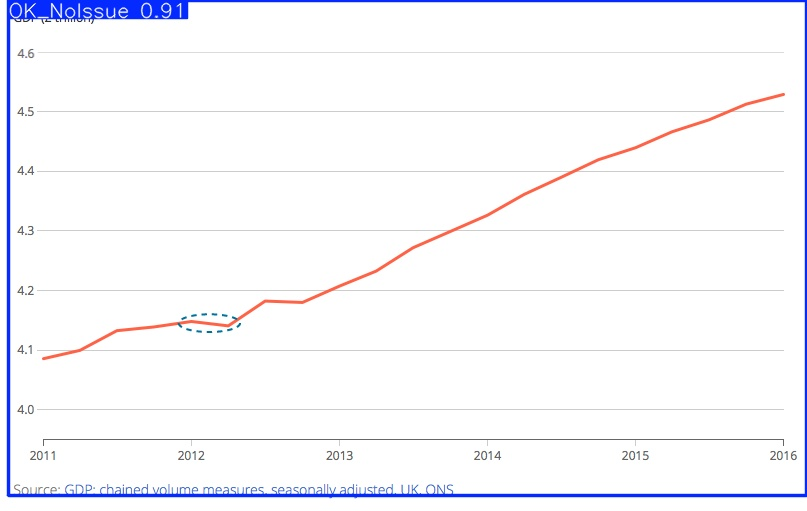

a7d8c7e6-ViBCo.png: S1_AxisNotZero (0.78) → ❌ NON-COMPLIANT


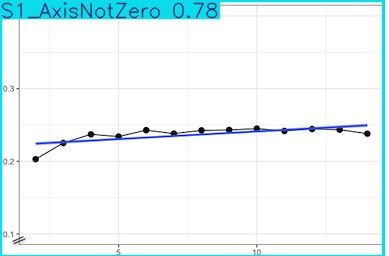

aeeba8b5-graph-1.png: OK_NoIssue (0.94) → ✅ COMPLIANT


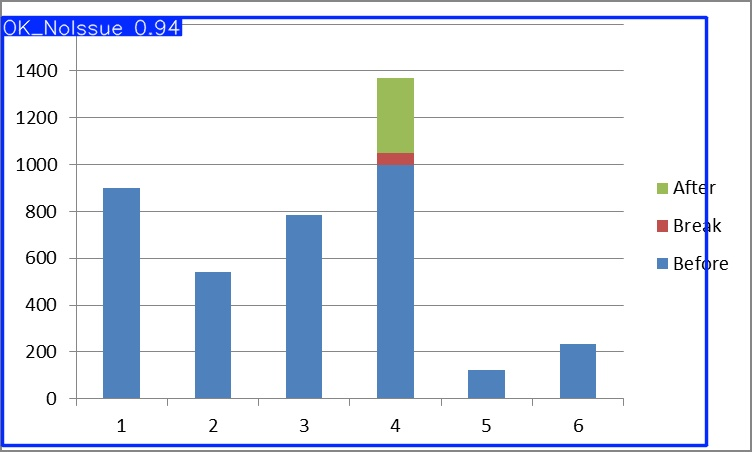

b33d4f4a-renditionDownloadd.jpeg: OK_NoIssue (0.87) → ✅ COMPLIANT


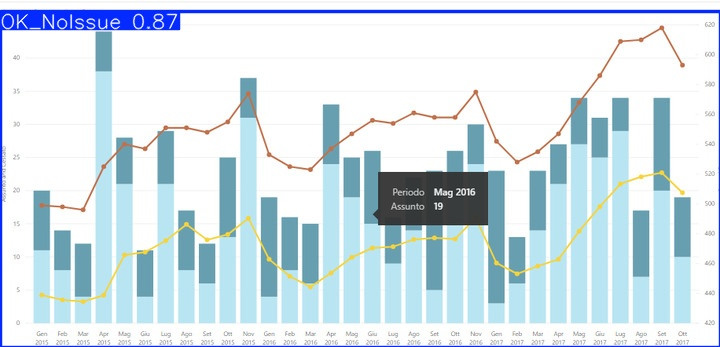

c6f42fb9-66006bf1d493d5a53c0e7545_4e3415_4afea0877ede4a569319f2bd0e6f8cfdmv2.png: OK_NoIssue (0.61) → ✅ COMPLIANT


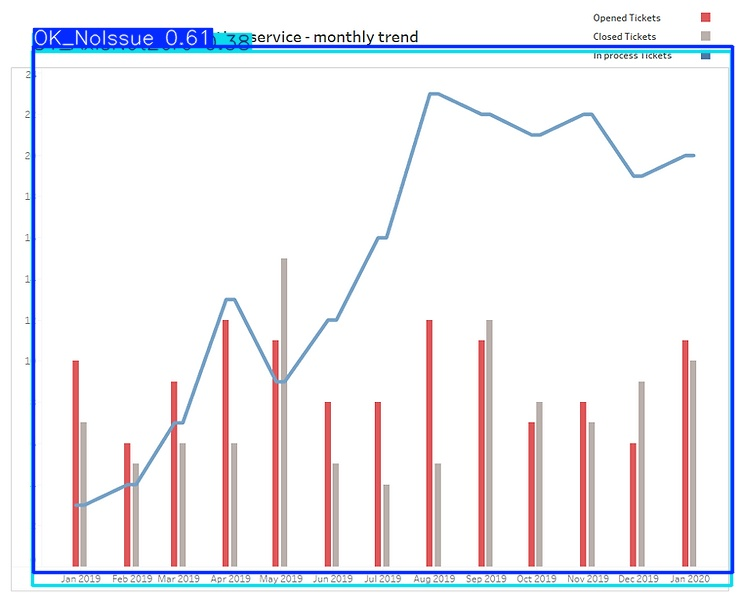

ca07eae9-Opal55_0-1616528223843.png: S1_AxisNotZero (0.69) → ❌ NON-COMPLIANT


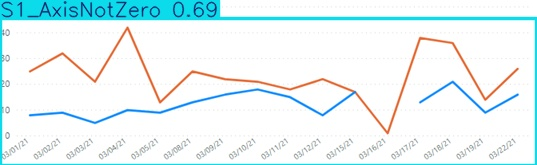

f4d7c145-gh.png: S1_AxisNotZero (0.94) → ❌ NON-COMPLIANT


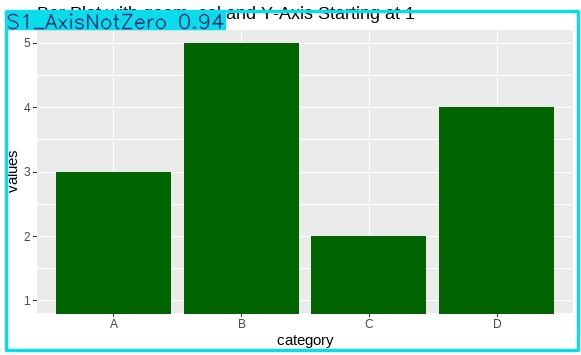

In [16]:
from ultralytics import YOLO
from pathlib import Path
from IPython.display import Image, display
import os

CLASS_NAMES = [
    "OK_NoIssue",
    "S1_AxisNotZero",
    "S2_UnequalTickSpacing",
    "S3_DistortedScaleRange",
    "S4_MissingAxisValues",
    "S5_MisusedDualAxis"
]

# Load the trained model
model = YOLO("runs/detect/ibcs_v2/weights/best.pt")

# Predict + save annotated images
results = model.predict(
    source="data/validation/images",
    conf=0.25,
    save=True,
    device="gpu" if torch.cuda.is_available() else "cpu"
)

# The ACTUAL folder where YOLO saved images
save_dir = Path(results[0].save_dir)
print("✅ Predictions saved to:", save_dir)

# Loop through each prediction result
for r in results:
    image_name = Path(r.path).name

    # If no detection
    if r.boxes is None or len(r.boxes) == 0:
        print(f"{image_name}: ❌ No chart detected")
        # Still show original image (optional)
        display(Image(filename=str(r.path), height=350))
        continue

    # If you expect one chart per image, take the best-confidence box
    best_idx = int(r.boxes.conf.argmax().item())
    cls_id = int(r.boxes.cls[best_idx].item())
    cls_name = CLASS_NAMES[cls_id]

    compliance = "✅ COMPLIANT" if cls_name == "OK_NoIssue" else "❌ NON-COMPLIANT"
    conf = float(r.boxes.conf[best_idx].item())

    print(f"{image_name}: {cls_name} ({conf:.2f}) → {compliance}")

    # Show the annotated saved image (same filename as input)
    pred_img_path = save_dir / image_name
    if pred_img_path.exists():
        display(Image(filename=str(pred_img_path), height=350))
    else:
        # Sometimes Ultralytics saves as .jpg even if input was .png
        alt = pred_img_path.with_suffix(".jpg")
        if alt.exists():
            display(Image(filename=str(alt), height=350))
        else:
            print("⚠️ Annotated image not found, showing original instead.")
            display(Image(filename=str(r.path), height=350))


In [ ]:
# from ultralytics import YOLO

# model = YOLO("runs/detect/train5/weights/best.pt")
# results = model.predict(
#     source="data/validation/images",
#     save=True,
#     device='cpu'
# )

# print("Done! Check runs/detect/predict")


image 1/4 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\38f7a673-b7d316394613fd7033d363787cb5677a65719a3f_2_462x375.png: 544x640 (no detections), 98.8ms
image 2/4 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\691d6be0-rule_34_lines_zero-03.webp: 640x544 (no detections), 77.8ms
image 3/4 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\a64a8224-rule_34_lines_zero-11.webp: 640x640 (no detections), 72.4ms
image 4/4 c:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\data\validation\images\f8007ff9-60094329-08a74780-974c-11e9-8ee1-e6a97ddc338c.png: 288x640 (no detections), 59.6ms
Speed: 5.3ms preprocess, 77.1ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)
Results saved to C:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\runs\detect\predict
Done! Check runs/detect/pr

Showing images from: C:\Users\ACER\Documents\Proftask\AI sem\Individual\Train YOLO\SchoolProject\runs\detect\predict7


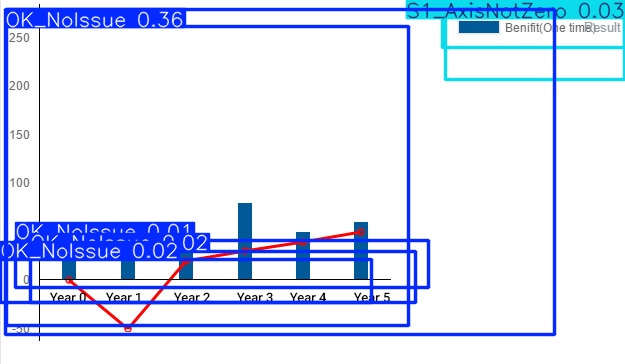

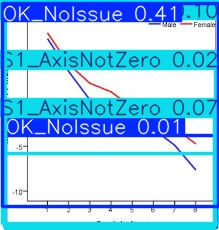

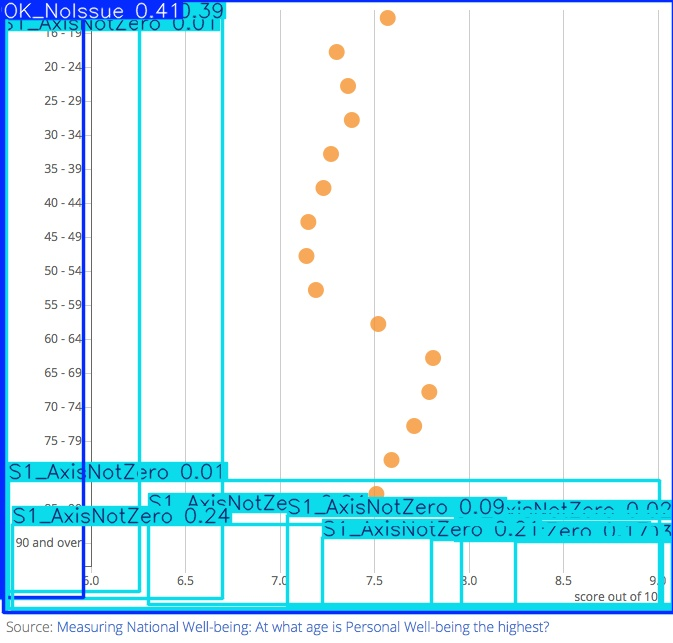

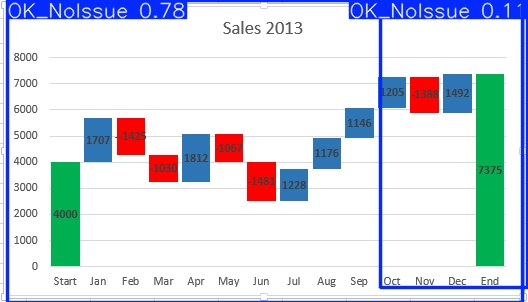

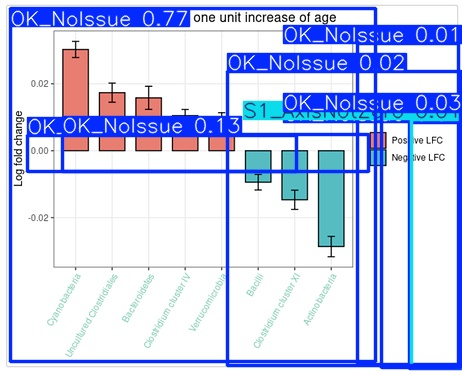

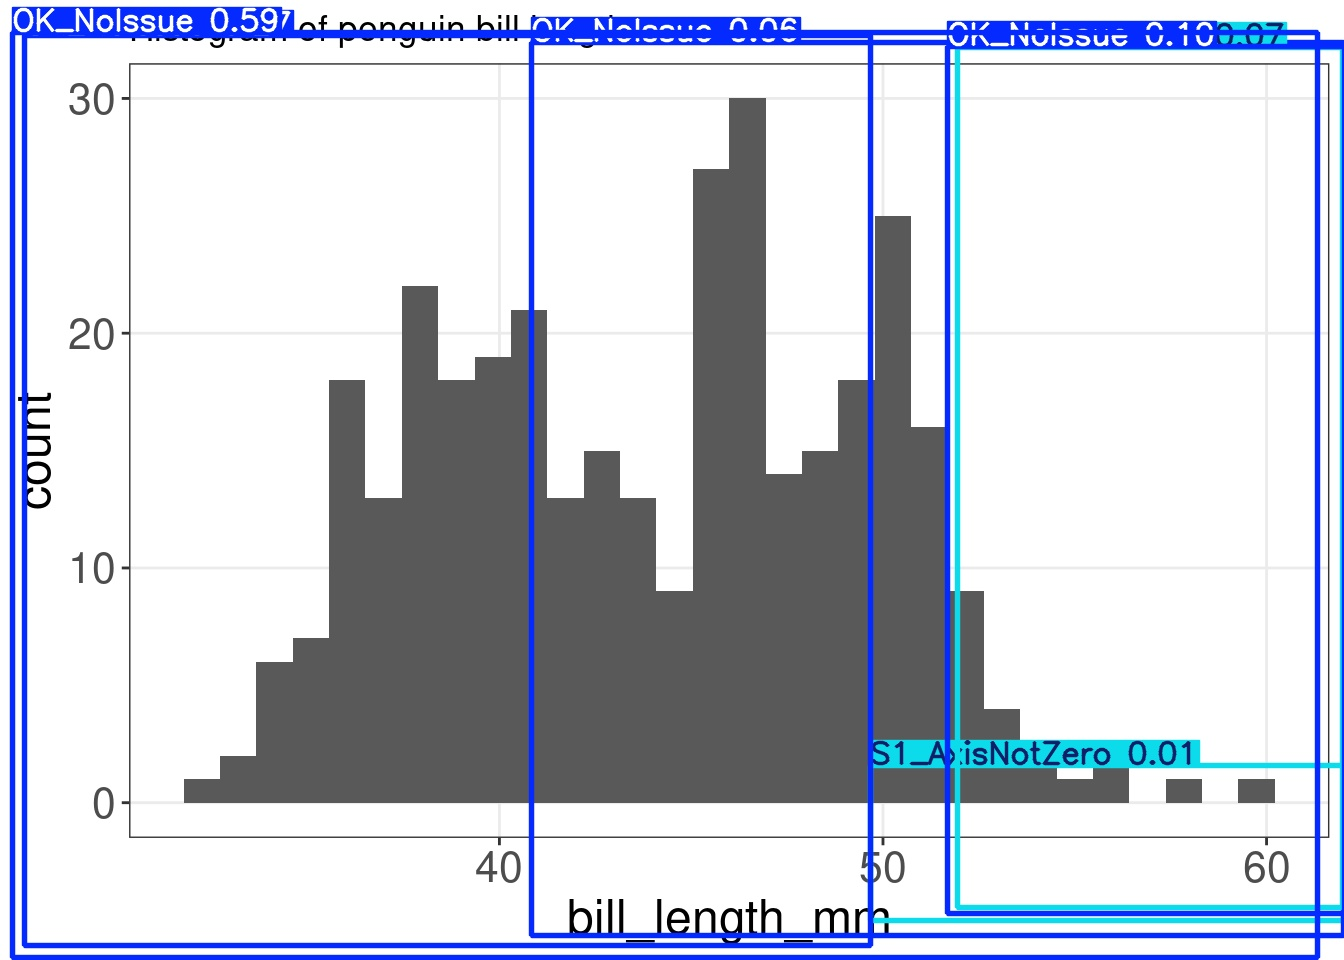

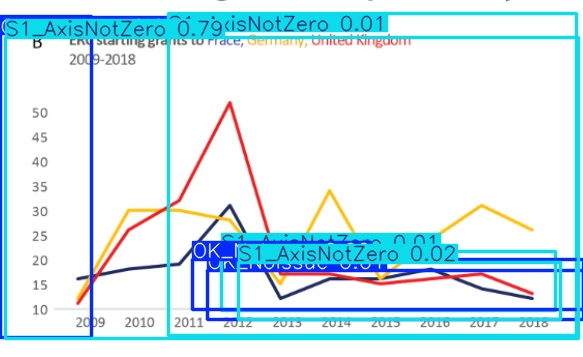

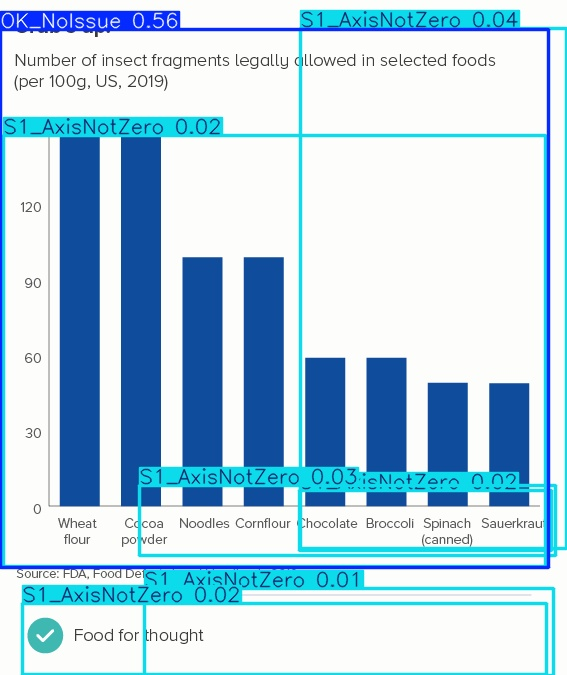

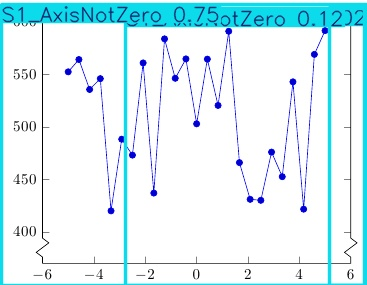

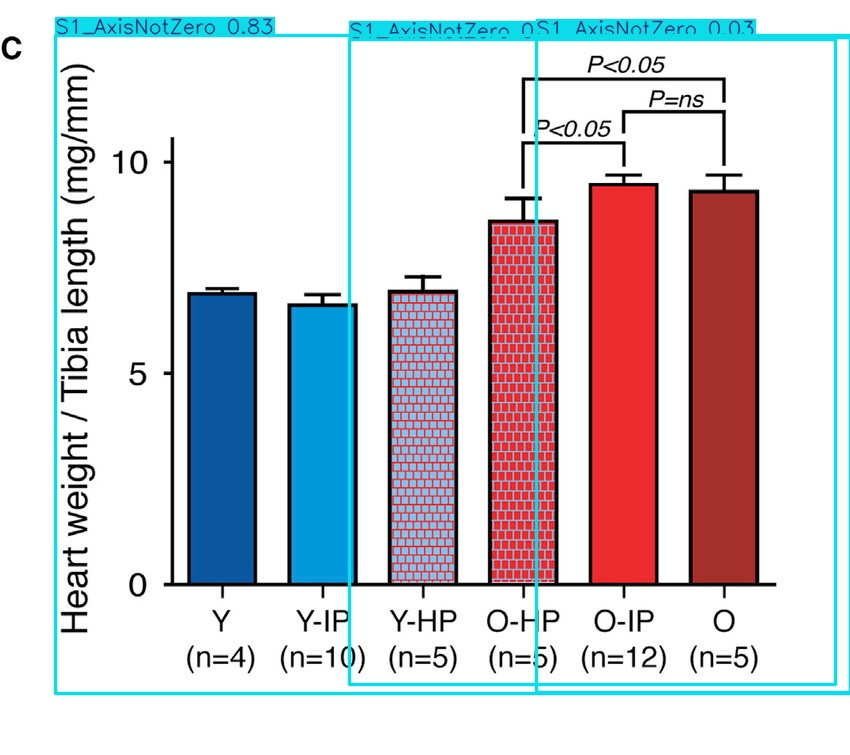

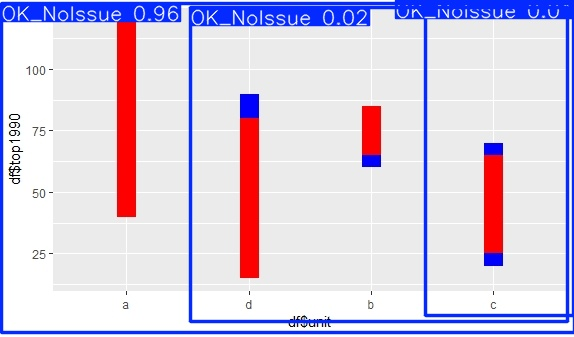

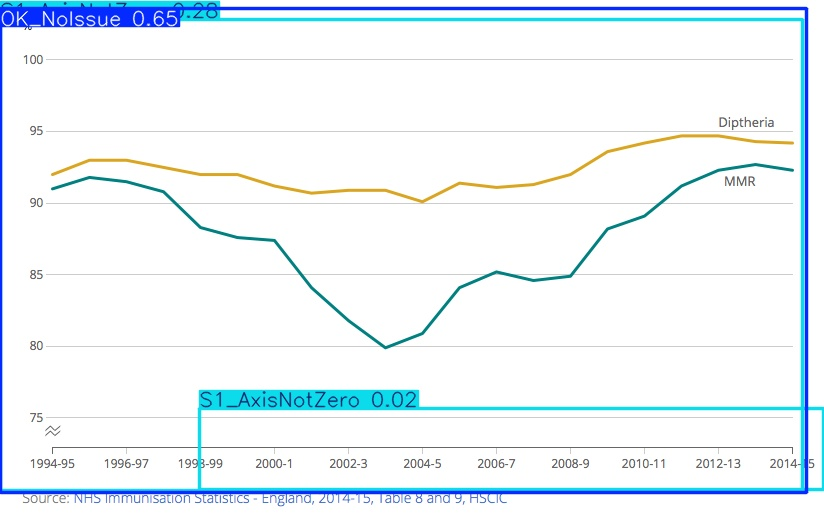

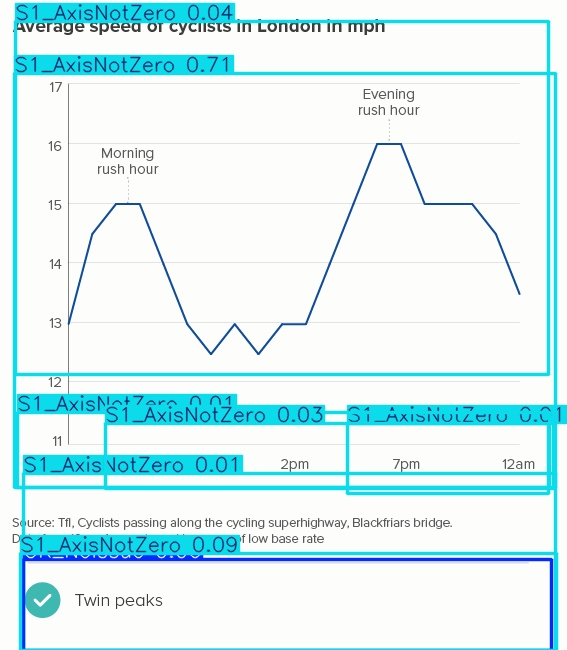

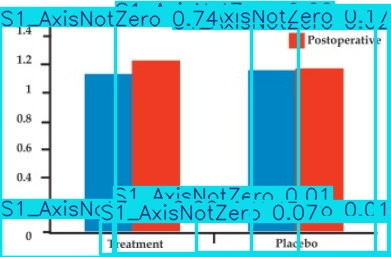

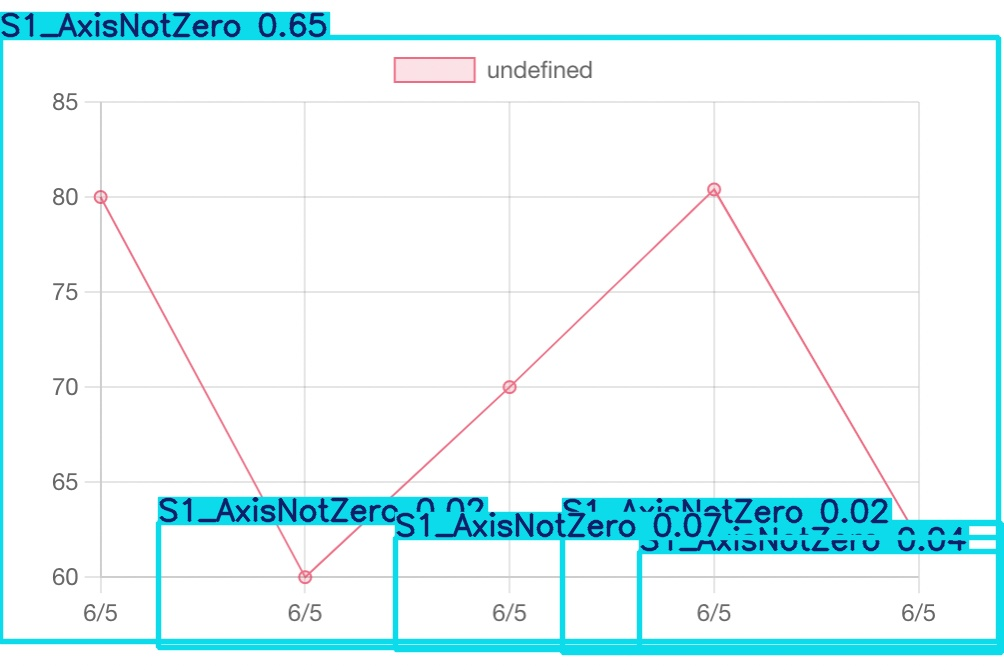

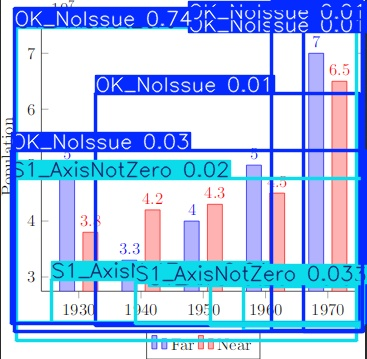

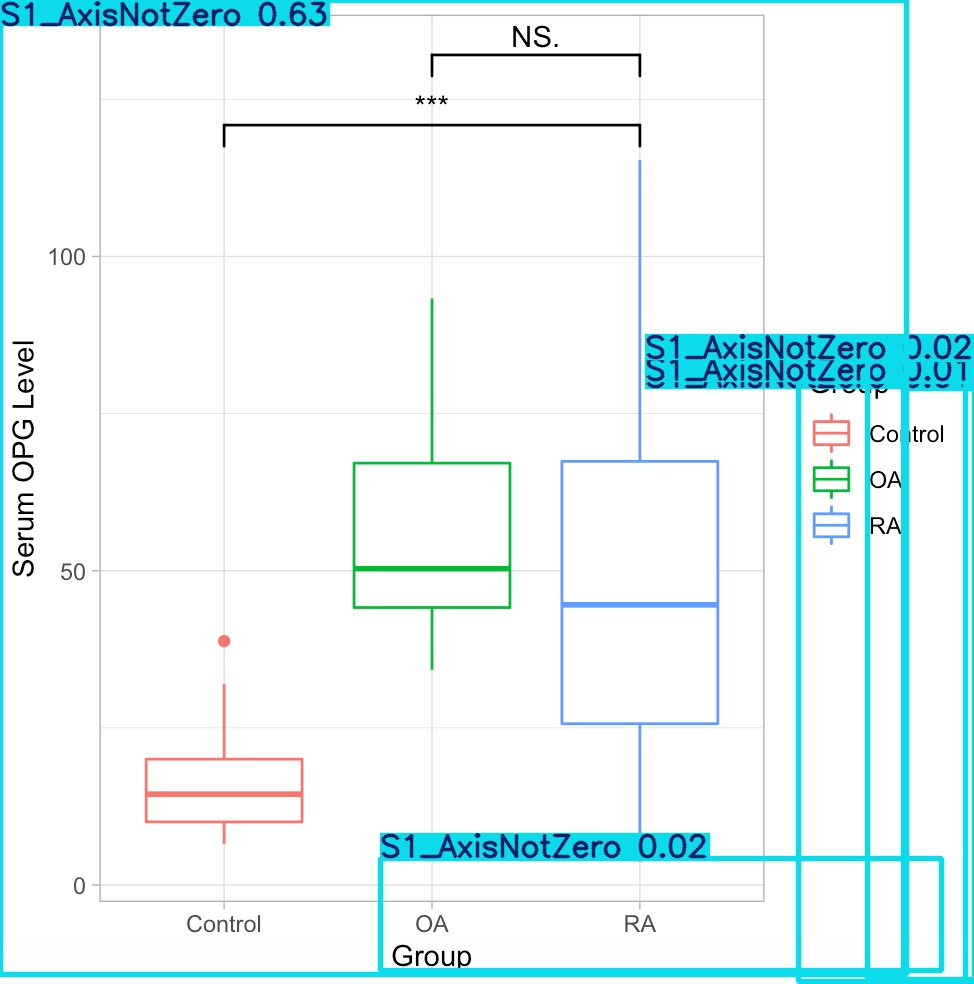

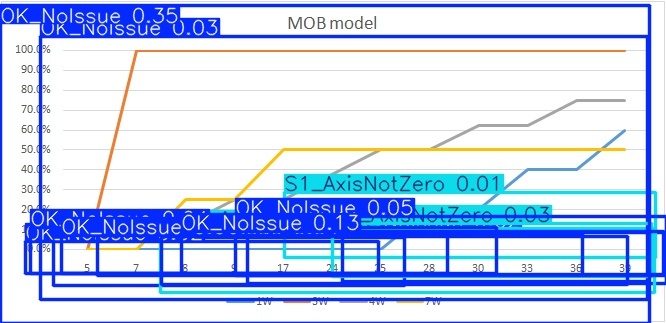

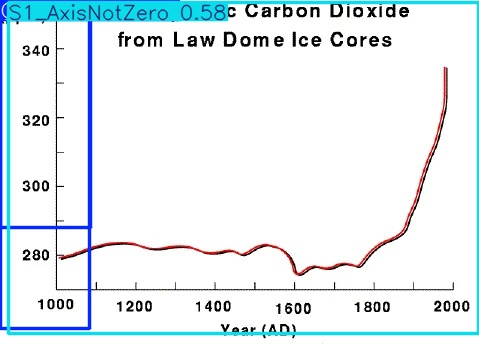

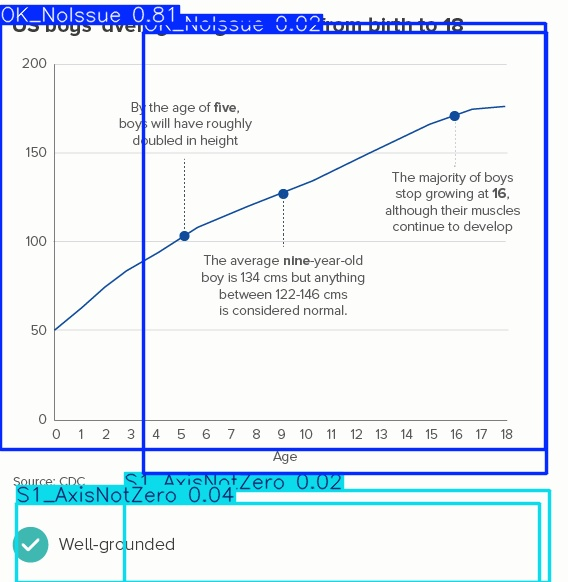

In [ ]:
import glob
from pathlib import Path
from IPython.display import Image, display

save_dir = Path(results[0].save_dir)  # the real output folder YOLO used
print("Showing images from:", save_dir)

for image_path in glob.glob(str(save_dir / "*.*"))[:20]:
    display(Image(filename=image_path, height=400))
    print("\n")
